## Options structural break detection, 3yrs

In [1]:
import os 
import numpy as np
import pandas as pd
from datetime import datetime
from pprint import pprint

In [2]:
import warnings
warnings.filterwarnings(action='once')
warnings.simplefilter('once', category=UserWarning)

In [3]:
from time_series_utils import timeseries_evaluation_metrics_func, mean_absolute_percentage_error,\
                          find_best_ARIMA_model, get_nth_train_split

Importing plotly failed. Interactive plots will not work.


## Cboe Options Historical Volume and Put/Call Ratios

### Index Options

In [4]:
from datetime import datetime, timedelta
import pickle

In [9]:
pickle_dir = "../results_pickle_format"

In [10]:
with open(f'{pickle_dir}/IDX_options.pkl', 'rb') as f:
    df2 = pickle.load(f)

In [11]:
df2 = df2[:'2013-01-01']


<AxesSubplot:xlabel='Date'>

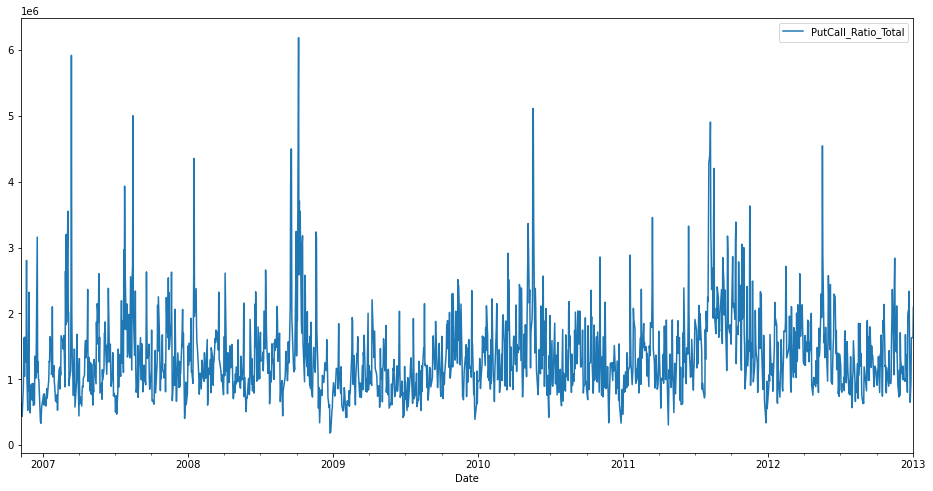

In [12]:
df2.plot(figsize=(16,8))

## What we are going to do. 

start_time + 6 months = interval_1 <- hyperparameter tuning 

then fit and predict the next 1 week. 

new start_time is interval_1 end + 1 weeks => 
start_time_1 + 6 months =  interval_2 <- hyperparameter tuning 

then fix and predict the next 1 week.

Repeat for 156 times. 

In [ ]:
TRAIN_WEEKS = 8

### Fine tune hyperparameter and forecast on moving window of 1 week increment up to 156 weeks (3 years) 

In [8]:
# Value Columns to be used in all models tuning
value_col = 'PutCall_Ratio_Total'

## ARIMA and SARIMAX Model

In [10]:
## create an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

In [11]:
# force update on hyperparameters
best_params = None 

In [12]:
%%capture

ARIMA_MAPES = []
steps = 156  # number of windowing steps (unit week)

for i in range(steps):
    train_data, val_data, test_data = get_nth_train_split(df2, i, train_week_len=TRAIN_WEEKS)
    _, _, best_pdq_MAE = find_best_ARIMA_model(
        train_data, val_data, value_col=value_col)
    model_ARIMA = ARIMA(train_data[value_col], order=best_pdq_MAE).fit()
    test_pred_ARIMA = model_ARIMA.predict(start=test_data.index[0], end=test_data.index[-1])
    MAPE = mean_absolute_percentage_error(test_data[value_col], test_pred_ARIMA)
    ARIMA_MAPES.append((MAPE, (test_data.index[0], test_data.index[-1])))
    print("*********************************************")
    print()
    print(f"finishing step: {i}")
    print()
    print("**********************************************")
     
print(f"Arima MAPES:\n {ARIMA_MAPES}")

In [13]:
import pickle

with open(f'{pickle_dir}/arima_interval_8w_IDX_2007-2009.pkl', 'wb') as f:
    pickle.dump(ARIMA_MAPES, f)

In [16]:
ARIMA_MAPES

[(23.672042085505055,
  (Timestamp('2007-01-09 00:00:00', freq='D'),
   Timestamp('2007-01-15 00:00:00', freq='D'))),
 (30.229284730639456,
  (Timestamp('2007-01-16 00:00:00', freq='D'),
   Timestamp('2007-01-22 00:00:00', freq='D'))),
 (48.07698893335371,
  (Timestamp('2007-01-23 00:00:00', freq='D'),
   Timestamp('2007-01-29 00:00:00', freq='D'))),
 (63.663253302053256,
  (Timestamp('2007-01-30 00:00:00', freq='D'),
   Timestamp('2007-02-05 00:00:00', freq='D'))),
 (84.12098852717854,
  (Timestamp('2007-02-06 00:00:00', freq='D'),
   Timestamp('2007-02-12 00:00:00', freq='D'))),
 (25.69469945633806,
  (Timestamp('2007-02-13 00:00:00', freq='D'),
   Timestamp('2007-02-19 00:00:00', freq='D'))),
 (52.130413262294226,
  (Timestamp('2007-02-20 00:00:00', freq='D'),
   Timestamp('2007-02-26 00:00:00', freq='D'))),
 (44.589231157229584,
  (Timestamp('2007-02-27 00:00:00', freq='D'),
   Timestamp('2007-03-05 00:00:00', freq='D'))),
 (23.573793119117344,
  (Timestamp('2007-03-06 00:00:00', f

In [17]:
arima_mapes_values = map(lambda x: x[0], ARIMA_MAPES) 
arima_mapes_df = pd.DataFrame(arima_mapes_values, columns=['mape'])
arima_mapes_df.head(3)

mape
0  23.672042
1  30.229285
2  48.076989

In [18]:
arima_mapes_norm = arima_mapes_df/arima_mapes_df.mean()
arima_mapes_norm.head(3)

mape
0  0.588583
1  0.751623
2  1.195390

In [19]:
arima_mapes_df.mean()

mape    40.218676
dtype: float64